In [20]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from pathlib import Path
from PIL import Image
from collections import defaultdict
from torchvision.models import resnet18, ResNet18_Weights
from umap.umap_ import UMAP
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
from tqdm import tqdm
import time
from torchvision.transforms import v2

In [21]:
class QuiltedDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)

        for img in self.image_files:
            if "positive" in img:
                self.labels.append(1)
            else:
                self.labels.append(0)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [22]:
# Define transformations (if needed)
transform = transforms.Compose([
    #transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/quilted_images_3snr/'
quilted_dataset = QuiltedDataset(folder_path, transform=transform)
quilted_dataloader = DataLoader(quilted_dataset, batch_size=32, shuffle=True)

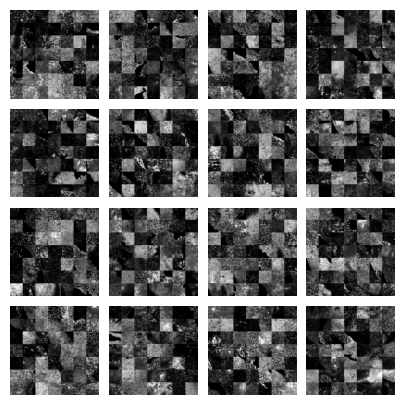

In [23]:
# Get a batch of 25 images for visualization
dataiter = iter(quilted_dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [24]:
class SingleChannelDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)

        # Store tumor type in self.labels (0 = fused glands, 1 = 141541, 2 = solid)
        for img in self.image_files:
            slide_num = img.split("/")[-1].split("_")[0][:6]
            tissue_num = img.split("/")[-1].split("_")[0][6:]
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [25]:
# Define transformations (if needed)
transform = transforms.Compose([
    #transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_3snr_greyscale/'
test_dataset = SingleChannelDataset(folder_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [70]:
# Dataset implementation for your specific case
class MultiChannelDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.sample_dict = defaultdict(list)
        self.labels = []
        self.samples = []


        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            full_image_path.sort()
            
            for img_path in full_image_path:
                img_array = self._load_image_as_tensor(img_path)
                self.sample_dict[img_path.split("/")[-1][:8]].append(img_array)
        # convert the dictionary into list so we can get the samples by indexing
        for sample in self.sample_dict:
            self.samples.append(self.sample_dict[sample])
            slide_num = sample[:6]
            tissue_num = sample[6:]
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)


        

    def _load_image_as_tensor(self, path):
        """
        Load an image as a NumPy array.
        
        Args:
            path (str): Path to image file
            
        Returns:
            np.ndarray: Image as NumPy array with shape [H, W]
        """
        # Open image using PIL
        with Image.open(path) as img:
            # Convert to grayscale if not already
            if img.mode != 'L':
                img = img.convert('L')
            # Convert to NumPy array
            img_np = np.array(img, dtype=np.float32)
            img_tensor = torch.from_numpy(img_np).unsqueeze(0)
            #transform the tensor if needed
            if self.transform:
                img_tensor = self.transform(img_tensor)
        return img
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        
        
        # Stack list of images for each tissue to form a 50-channel tensor
        sample_tensor = torch.stack(sample, dim=0)  # Shape: [50, H, W]
        sample_tensor = sample_tensor.squeeze(1) # remove the color channel for each individual image, so the multidimensional
            
        return sample_tensor, label

In [40]:
class MultiChannelResnet(nn.Module):
    def __init__(self, num_channels=50, num_classes=2):
        """
        Modified ResNet model to handle multi-channel inputs beyond RGB.
        
        Args:
            num_channels (int): Number of input channels (default: 50)
            num_classes (int): Number of output classes (default: 2)
        """
        super(MultiChannelResnet, self).__init__()
        
        # Load a pretrained ResNet model
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Replace the first convolutional layer to accept num_channels instead of 3
        original_layer = self.model.conv1
        new_layer = nn.Conv2d(
            num_channels, 
            original_layer.out_channels,
            kernel_size=original_layer.kernel_size,
            stride=original_layer.stride,
            padding=original_layer.padding,
            bias=(original_layer.bias is not None)
        )
        
        # Initialize the new layer with scaled weights from pretrained model
        with torch.no_grad():
            # Scale the weights to maintain activation magnitude
            scale_factor = 3 / num_channels  # 3 is original RGB channels
            # Only use the first 3 channels for initialization if using pretrained weights
            if num_channels > 3:
                new_layer.weight[:, :3, :, :] = original_layer.weight * scale_factor
                # Initialize remaining channels with small random values
                nn.init.kaiming_normal_(new_layer.weight[:, 3:, :, :], mode='fan_out')
            else:
                new_layer.weight = torch.nn.Parameter(original_layer.weight[:, :num_channels, :, :] * scale_factor)
        
        # Replace the layer
        self.model.conv1 = new_layer
        
        # Modify the final fully connected layer for binary classification
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, num_channels, height, width]
        
        Returns:
            torch.Tensor: Output predictions of shape [batch_size, num_classes]
        """
        return self.model(x)

In [42]:
def train_model_with_visualization(model, criterion, optimizer, train_loader, test_loader, epochs=20):
    device = "cuda"
    # Lists to store metrics for visualization
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    

    best_val_loss = float('inf')
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / total
        # Store training metrics
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        
        # Testing phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        # Calculate testing metrics
        test_accuracy = correct / total
        
        # Store validation metrics
        val_losses.append(val_loss)
        val_accs.append(test_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {test_accuracy:.4f}')
        
                # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_restnet_classifier.pt')
            print(f"Saved new best model with validation loss: {val_loss:.4f}")
    print(train_accs)
    print(val_accs)
    
    return train_losses,val_losses, train_accs, val_accs

def plot_metrics(train_losses,val_losses, train_accs, val_accs, epochs=20):
    """
    Plot training and validation metrics.
    
    Args:
        train_losses: List of training losses per epoch
       val_losses: List of validation losses per epoch
        train_accs: List of training accuracies per epoch
        val_accs: List of validation accuracies per epoch
        epochs: Number of training epochs
    """
    epochs_range = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs_range,val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, epochs + 1, step=max(1, epochs // 10)))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, epochs + 1, step=max(1, epochs // 10)))
    plt.ylim([0, 1])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()


In [48]:
train_size = int(0.6 * len(quilted_dataset))  # 60% for training
test_size = len(quilted_dataset) - train_size  # Remaining 40% for testing
train_quilted_dataset, test_quilted_dataset = random_split(quilted_dataset, [train_size, test_size], generator = torch.Generator().manual_seed(42))

# Define DataLoaders
train_quilted_loader = DataLoader(train_quilted_dataset, batch_size=32, shuffle=True)
test_quilted_loader = DataLoader(test_quilted_dataset, batch_size=32, shuffle=False)

# Create model
model = MultiChannelResnet(num_channels=1, num_classes=2).to("cuda")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)

# Train with visualization
train_losses, val_losses, train_accs, val_accs = train_model_with_visualization(model, criterion, optimizer, train_quilted_loader, test_quilted_loader)

Epoch 1/20, Train Loss: 4.4177, Train Acc: 0.9567, Val Loss: 54.1629, Val Acc: 0.6913
Saved new best model with validation loss: 54.1629
Epoch 2/20, Train Loss: 0.9789, Train Acc: 0.9908, Val Loss: 2.4992, Val Acc: 0.9663
Saved new best model with validation loss: 2.4992
Epoch 3/20, Train Loss: 0.0617, Train Acc: 0.9992, Val Loss: 0.6108, Val Acc: 0.9900
Saved new best model with validation loss: 0.6108
Epoch 4/20, Train Loss: 0.0156, Train Acc: 1.0000, Val Loss: 0.2351, Val Acc: 0.9975
Saved new best model with validation loss: 0.2351
Epoch 5/20, Train Loss: 0.0219, Train Acc: 1.0000, Val Loss: 0.3024, Val Acc: 0.9962
Epoch 6/20, Train Loss: 0.0126, Train Acc: 1.0000, Val Loss: 0.0677, Val Acc: 1.0000
Saved new best model with validation loss: 0.0677
Epoch 7/20, Train Loss: 0.0111, Train Acc: 1.0000, Val Loss: 0.0626, Val Acc: 1.0000
Saved new best model with validation loss: 0.0626
Epoch 8/20, Train Loss: 0.0063, Train Acc: 1.0000, Val Loss: 0.1026, Val Acc: 0.9988
Epoch 9/20, Train 

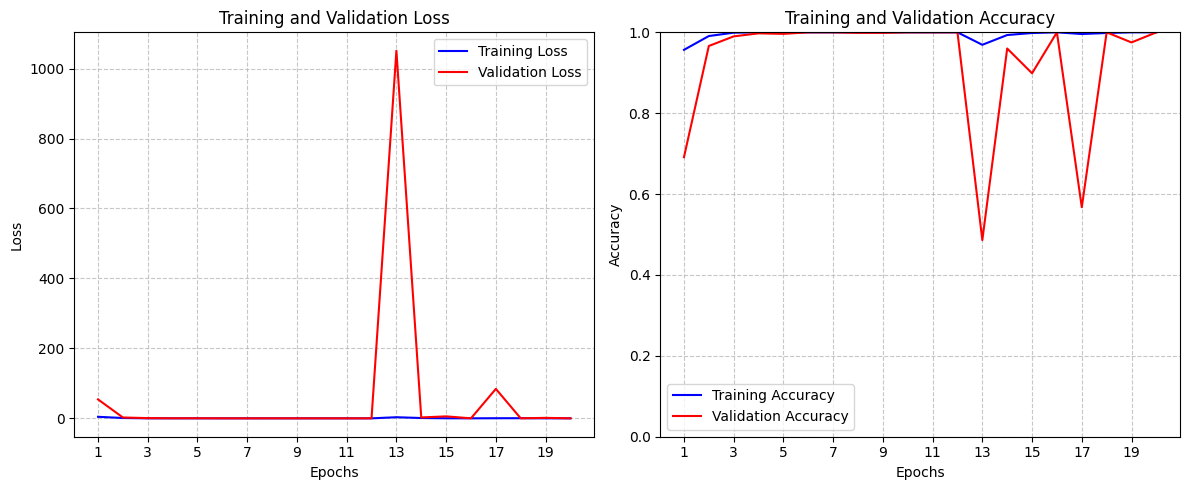

In [49]:

plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [51]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load the saved model
model = MultiChannelResnet(num_channels=1, num_classes=2).to('cpu')
model.load_state_dict(torch.load('best_restnet_classifier.pt', map_location=torch.device('cpu')))
model.eval()  # Set to evaluation mode


# 3. Make predictions
predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        all_labels.extend(labels.cpu().numpy())
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

y_pred = np.array(predictions)
y_true = np.array(all_labels)
print(y_pred)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

[1 1 1 ... 1 1 1]
Accuracy: 0.5779

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.17      0.29      2440
           1       0.54      0.99      0.70      2440

    accuracy                           0.58      4880
   macro avg       0.73      0.58      0.49      4880
weighted avg       0.73      0.58      0.49      4880


Confusion Matrix:
[[ 414 2026]
 [  34 2406]]
